# DATA 607 - Machine Learning

## Class 5 &mdash; 2025.07.14


### Text Data (Part 2). Dimension Reduction. Regularization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

bunch = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
assert isinstance(bunch, Bunch)

X = bunch.data
y = bunch.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
print(len(X_train), len(X_test))

5657 5657


### `LogisticRegression`

In [2]:
model = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.2), LogisticRegression()
)
model.fit(X_train, y_train)
print(f"{accuracy_score(y_train, model.predict(X_train))=}")
print(f"{accuracy_score(y_test, model.predict(X_test))}")

accuracy_score(y_train, model.predict(X_train))=0.9741912674562488
0.6611278062577338


In [3]:
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10]}
model = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.2), LogisticRegression()
)
search = GridSearchCV(model, param_grid, scoring="accuracy")
best_model = search.fit(X_train, y_train).best_estimator_  # returns the best estimator
display(best_model)

print(f"{search.best_params_=}")
print(f"{search.best_score_=}")
print(f"{accuracy_score(y_test, best_model.predict(X_test))=}")

,steps,"[('countvectorizer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


search.best_params_={'logisticregression__C': 0.1}
search.best_score_=np.float64(0.6519379953948005)
accuracy_score(y_test, best_model.predict(X_test))=0.6749160332331624


### `SGDClassifier`

In [4]:
from sklearn.linear_model import SGDClassifier

param_grid = {"sgdclassifier__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0]}
model = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.2), SGDClassifier()
)
search = GridSearchCV(model, param_grid, scoring="accuracy")
best_model = search.fit(X_train, y_train).best_estimator_  # returns the best estimator
display(best_model)

print(f"{search.best_params_=}")
print(f"{search.best_score_=}")
print(f"{accuracy_score(y_test, best_model.predict(X_test))=}")

,steps,"[('countvectorizer', ...), ('sgdclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


search.best_params_={'sgdclassifier__alpha': 0.01}
search.best_score_=np.float64(0.6791600666098047)
accuracy_score(y_test, best_model.predict(X_test))=0.6940074244299098


##### `Normalizer` to normalize rows

- Contrast with `StandardScaler` that operates on columns.

In [5]:
from sklearn.preprocessing import Normalizer

A = np.random.normal(size=(2, 4))

normalizer = Normalizer()

assert np.allclose(
    normalizer.fit_transform(A), A / np.linalg.norm(A, axis=1, keepdims=True)
)

In [6]:
U = make_pipeline(CountVectorizer()).fit_transform(X_train[:10])
V = make_pipeline(CountVectorizer(), Normalizer()).fit_transform(X_train[:10])
assert np.allclose(
    V.todense(), U.todense() / np.linalg.norm(U.todense(), axis=1, keepdims=True)
)

In [7]:
from collections import Counter

Counter(y_train)

Counter({np.int64(15): 314,
         np.int64(11): 311,
         np.int64(5): 309,
         np.int64(2): 304,
         np.int64(13): 304,
         np.int64(14): 300,
         np.int64(3): 300,
         np.int64(10): 298,
         np.int64(9): 295,
         np.int64(1): 293,
         np.int64(7): 292,
         np.int64(6): 291,
         np.int64(8): 289,
         np.int64(17): 288,
         np.int64(4): 287,
         np.int64(12): 282,
         np.int64(16): 265,
         np.int64(18): 224,
         np.int64(0): 215,
         np.int64(19): 196})

- Default parameter values usually work better with normalized data.

In [8]:
# Normalize the count data, can use the default value for alpha in SGDClassifier

from sklearn.linear_model import SGDClassifier


model = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.2), Normalizer(), SGDClassifier()
)
display(model)

model.fit(X_train, y_train)
print(f"{accuracy_score(y_test, model.predict(X_test))=}")

,steps,"[('countvectorizer', ...), ('normalizer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


accuracy_score(y_test, model.predict(X_test))=0.7077956514053385


### `SVC` (Support Vector Classifier)

In [9]:
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer

model = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.2),
    Normalizer(),  # SVC is sensitive to normalization!
    SVC(kernel="linear", C=1.0),
)

model.fit(X_train, y_train)
print(f"{accuracy_score(y_test, model.predict(X_test))=}")

accuracy_score(y_test, model.predict(X_test))=0.6659006540569207


In [10]:
from sklearn.svm import LinearSVC

model = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.2),
    Normalizer(),  # LinearSVC is sensitive to normalization!
    LinearSVC(loss="hinge", max_iter=1000),
)

model.fit(X_train, y_train)

print(f"{accuracy_score(y_test, model.predict(X_test))=}")

accuracy_score(y_test, model.predict(X_test))=0.709916917093866


### IDF (Inverse Document Frequency) weighting

- Words that apear in lots of documents, are "less informative".

- ***Document frequency*** of the term $t$:
  $$
  \begin{aligned}
  \operatorname{df}(t) &= \text{proportion of documents containing $t$}
  \end{aligned}
  $$

- ***Inverse document frequency*** of the term $t$:
  $$
  \operatorname{idf}(t) = \log\frac1{\operatorname{df}(t)}
  $$
  Even though it's not reflected in the name, the logarithmic scaling is standard.

- Scikit Learn does some extra smoothing by default, so these aren't the exact quantities it computes.

### `TfidfVectorizer`

- Weights each term-count by the corresponding inverse document frequency.

- Concretely, `TfidfVectorizer` multiplies the $j$-th column of the count matrix returned by `CountVectorizer.transform` by the inverse document frequency of the $j$-th term. Each row of the resulting matrix is then normalized to have length $1$.

- This is a bit tricky in practice because of *sparse matrices*, but here it is explicitly:

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

count_vectorizer = CountVectorizer().fit(X_train)
counts = count_vectorizer.transform(X_train)

tfidf_vectorizer = TfidfVectorizer().fit(X_train)
assert tfidf_vectorizer.vocabulary_ == count_vectorizer.vocabulary_


document_indices, term_indices = counts.nonzero()
smoothed_counts = counts.astype(float)
idf_weights = tfidf_vectorizer.idf_[term_indices]
smoothed_counts.data *= idf_weights

assert np.allclose(
    normalize(smoothed_counts).data, tfidf_vectorizer.transform(X_train).data
)
assert np.all(
    normalize(smoothed_counts).indices == tfidf_vectorizer.transform(X_train).indices
)

- Let's try it out with `LinearSVC`

In [12]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer


model = make_pipeline(
    TfidfVectorizer(),
    LinearSVC(loss="hinge", max_iter=1000),
)

model.fit(X_train, y_train)

print(f"{accuracy_score(y_test, model.predict(X_test))}")

0.7300689411348772


### Back to `MultinomialNaiveBayes`

In [13]:
from sklearn.naive_bayes import MultinomialNB

model = make_pipeline(
    TfidfVectorizer(
        stop_words="english"
    ),  # Try letting stop_words revert to the default!
    MultinomialNB(alpha=0.1),
)

model.fit(X_train, y_train)

print(f"{accuracy_score(y_test, model.predict(X_test))=}")

accuracy_score(y_test, model.predict(X_test))=0.7194626126922397


- Retune `alpha`...

In [14]:
param_grid = {
    "tfidfvectorizer__stop_words": [None, "english"],
    "multinomialnb__alpha": np.logspace(-2, -1, 20),
}

# With a higher value of alpha, stop-words don't help anymore.
# Regularization can often be used in place of feature selection.

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

search = GridSearchCV(model, param_grid, scoring="accuracy")
best_model = search.fit(X_train, y_train).best_estimator_
display(best_model)

print(f"{search.best_params_=}")
print(f"{search.best_score_=}")
print(f"{accuracy_score(y_test, best_model.predict(X_test))=}")

,steps,"[('tfidfvectorizer', ...), ('multinomialnb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


search.best_params_={'multinomialnb__alpha': np.float64(0.011288378916846888), 'tfidfvectorizer__stop_words': 'english'}
search.best_score_=np.float64(0.7226460838621189)
accuracy_score(y_test, best_model.predict(X_test))=0.7353721053561959


## Pretrained embeddings

### GLoVe embeddings

- Pennington, Socher, Manning (2014). **GloVe: Global Vectors for Word Representation**.

- https://nlp.stanford.edu/projects/glove/


```bash
wget http://nlp.stanford.edu/data/glove.6B.zip
unzip -l glove.6B.zip
```

```output
Archive:  glove.6B.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
171350079  08-04-2014 14:15   glove.6B.50d.txt
347116733  08-04-2014 14:14   glove.6B.100d.txt
693432828  08-04-2014 14:14   glove.6B.200d.txt
1037962819  08-27-2014 13:19   glove.6B.300d.txt
---------                     -------
2249862459                     4 files
```

In [18]:
# Python
embeddings = np.zeros((400000, 300))
vocabulary = []

with open("glove.6B.300d.txt") as f:
    for i, line in enumerate(f):
        word, coeffs = line.split(maxsplit=1)
        vec = np.fromstring(coeffs, sep=" ")
        if vec.shape[0] != 300:
            continue  # skip malformed lines
        vocabulary.append(word)
        embeddings[i] = vec

print(len(vocabulary))

894


In [20]:
counter = CountVectorizer(vocabulary=vocabulary, stop_words="english")
counts_train = counter.fit_transform(X_train)
counts_test = counter.transform(X_test)

# W_train = normalize(counts_train @ embeddings)
# W_test = normalize(counts_test @ embeddings)
# Use only the rows corresponding to the CountVectorizer vocabulary
W_train = normalize(counts_train @ embeddings[:len(vocabulary)])
W_test = normalize(counts_test @ embeddings[:len(vocabulary)])

In [21]:
W_train.shape, W_test.shape

((5657, 300), (5657, 300))

In [22]:
from sklearn.linear_model import SGDClassifier

model = LinearSVC()

model.fit(W_train, y_train)
print(f"{accuracy_score(y_test, model.predict(W_test))=}")

accuracy_score(y_test, model.predict(W_test))=0.36114548347180486


### GTE (General Text Embeddings)

- See [https://huggingface.co/thenlper/gte-small](https://huggingface.co/thenlper/gte-small).

![GTE Model Card](assets/gte_small_model_card.png)

In [23]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("thenlper/gte-small")
X_train_gte_small = model.encode(X_train)
X_test_gte_small = model.encode(X_test)

# Takes a few minutes...

In [24]:
np.savez(
    "20newsgroups_gte_small.npz",
    X_train_gte_small=X_train_gte_small,
    X_test_gte_small=X_test_gte_small,
    y_train=y_train,
    y_test=y_test,
)

In [25]:
data = np.load("20newsgroups_gte_small.npz")
X_train_gte_small = data["X_train_gte_small"]
X_test_gte_small = data["X_test_gte_small"]
y_train = data["y_train"]
y_test = data["y_test"]

print(
    f"{X_train_gte_small.shape}\n{X_test_gte_small.shape=}\n{y_train.shape=}\n{y_test.shape=}"
)

(5657, 384)
X_test_gte_small.shape=(5657, 384)
y_train.shape=(5657,)
y_test.shape=(5657,)


In [26]:
model = SGDClassifier()
model.fit(X_train_gte_small, y_train)
accuracy_score(y_test, model.predict(X_test_gte_small))

0.7148665370337635

In [27]:
model = LinearSVC()
model.fit(X_train_gte_small, y_train)
accuracy_score(y_test, model.predict(X_test_gte_small))

0.7360791939190383

### Proximity in embedding space reflects semantic similarity

- Euclidean distance in embedding space:
  $$
  \operatorname{L}(x, x') = \|\operatorname{embedding}(x) - \operatorname{embedding}(x')\|
  $$

- Cosine similarity in embedding space:
  $$
  \operatorname{S}(x, x') = \cos\big(\text{angle between $\operatorname{embedding}(x)$ and $\operatorname{embedding}(x')$}\big)
  $$

In [28]:
X_test[i]

'Update your 385 to HP-UX 9.0.  You get an R5 server and libraries.'

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from collections import Counter

i = 666

x = X_test_gte_small[i]
print(f"{y_test[i]=}")

I = (
    cosine_similarity(x.reshape(1, -1), X_train_gte_small)
    .squeeze()
    .argsort()[::-1][:50]
)

print(f"{Counter(y_train[I])=}")

nns = NearestNeighbors()
nns.fit(X_train_gte_small)
distances, J = nns.kneighbors(x.reshape(1, -1), 50)
J = J.squeeze()
print(f"{Counter(y_train[J])=}")

y_test[i]=np.int64(11)
Counter(y_train[I])=Counter({np.int64(11): 50})
Counter(y_train[J])=Counter({np.int64(11): 50})


### Relevance of a document to a query

- We want to retrieve documents from a collection that are most relevant to a query.

- There are many ways to assign a **relevance score** $\operatorname{score}(D, Q)$ indicating the relevance of a document $D$ to a query $Q$.

- BM25:
  $$
  \operatorname{S}(D, Q) = \sum_{t\in Q}\operatorname{idf}(t)
  \frac{f(t, D)(k_1 + 1)}{f(t, D) + k_1\left(1 - b + b\frac{\operatorname{len}(D)}{\text{av.doc.len.}}\right)}
  $$
  Here, $f(t, D)$ be the frequency of occurence of term $t$ in document $D$, i.e., how many times it appears.

#### Vector search

- Euclidean distance in embedding space:
  $$
  \operatorname{S}(D, Q) = \|\operatorname{embedding}(D) - \operatorname{embedding}(Q)\|
  $$

- Cosine similarity in embedding space:
  $$
  \operatorname{S}(D, Q) = \cos\big(\text{angle between $\operatorname{embedding}(D)$ and $\operatorname{embedding}(Q)$}\big)
  $$

- Used for semantic search, recommendation/ranking, ...

- The R in RAG (Retrieval Augmented Generation)

### Multimodal embeddings

Small taste of multimodal embeddings: See [this colab notebook](https://colab.research.google.com/drive/1hm4M13xaOw1EteWZDfo_nShjFA44f5iO?usp=sharing).

In [30]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    RepeatedKFold,
)
from sklearn.linear_model import (
    Lasso,
    LogisticRegression,
    LinearRegression,
    Ridge,
)
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [31]:
df = pd.read_csv(
    "data/auto_preprocessed.csv",
)

display(df)

X = df.copy()
y = X.pop("mpg")

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,is_european,is_japanese
0,18.0,8,307.0,130.0,3504,12.0,70,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,0,0
...,...,...,...,...,...,...,...,...,...
385,36.0,4,135.0,84.0,2370,13.0,82,0,0
386,27.0,4,151.0,90.0,2950,17.3,82,0,0
387,27.0,4,140.0,86.0,2790,15.6,82,0,0
388,44.0,4,97.0,52.0,2130,24.6,82,1,0


- Including quadratic features improves CV-MSE over linear regression.

- Inluding cubic features severely degrades CV-MSE.

In [32]:
param_grid = {
    "polynomialfeatures__degree": [1, 2, 3],
}
model = make_pipeline(PolynomialFeatures(include_bias=False), LinearRegression())

search = GridSearchCV(
    model,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=RepeatedKFold(n_repeats=100, random_state=42),
)

search.fit(X, y)
pd.DataFrame(search.cv_results_)[
    ["param_polynomialfeatures__degree", "mean_test_score", "rank_test_score"]
]

,param_polynomialfeatures__degree,mean_test_score,rank_test_score
0,1,-11.390829,2
1,2,-8.265291,1
2,3,-218.001368,3


In [33]:
PolynomialFeatures(degree=3).fit_transform(X).shape

(390, 165)

### Principal Component Analysis (PCA)

- Each row of the degree 3 `PolynomialFeatures` transform of `X` is 164-dimensnional.

- **Principal component analysis (PCA)** identifies optimal lower dimensional projections of these row vectors.

- Hopefully, what's lost in these projections is "noise".

- PCA operates only on the feature matrix `X`. The target vector `y` is not involved.

In [35]:
from sklearn.decomposition import PCA
from icecream import ic

model = make_pipeline(
    PolynomialFeatures(include_bias=False, degree=3),
    StandardScaler(),
    PCA(n_components=45),
    LinearRegression(),
)

scores = cross_val_score(
    model, X, y, scoring="neg_mean_squared_error", cv=RepeatedKFold(n_repeats=100)
)
ic(scores.mean())

ic| scores.mean(): np.float64(-8.348713762146538)


np.float64(-8.348713762146538)

#### PCA for visualization

- PCA is often used to project high dimensional data into two dimensions to facilitate visualization.

##### ICMR Dataset

> The input dataset contains 802 samples for the corresponding 802 people who have been detected with different types of cancer. Each sample contains expression values of more than 20K genes. Samples have one of the types of tumours: BRCA, KIRC, COAD, LUAD, and PRAD.
>
> Source: [https://www.kaggle.com/datasets/shibumohapatra/icmr-data/data](https://www.kaggle.com/datasets/shibumohapatra/icmr-data/data)

In [36]:
X = pd.read_csv("data/data.csv").drop(columns=["Unnamed: 0"])
y = pd.read_csv("data/labels.csv")["Class"]
display(X.head())

y.value_counts()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


Class
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64

In [37]:
y

0      PRAD
1      LUAD
2      PRAD
3      PRAD
4      BRCA
       ... 
796    BRCA
797    LUAD
798    COAD
799    PRAD
800    PRAD
Name: Class, Length: 801, dtype: object

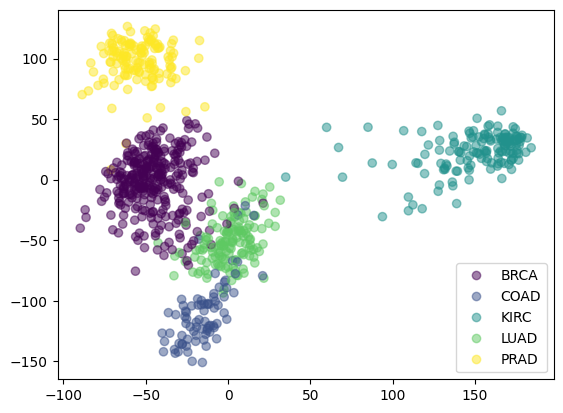

In [38]:
from sklearn.preprocessing import LabelEncoder

pca = PCA(n_components=2)
XX = pca.fit_transform(X)

label_encoder = LabelEncoder()
yy = label_encoder.fit_transform(y)

scatter = plt.scatter(XX[:, 0], XX[:, 1], c=yy, alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=list(label_encoder.classes_))
plt.show()

In [39]:
cross_val_score(LogisticRegression(), X, y, scoring="accuracy").mean()

np.float64(0.9975155279503106)

- The interest here is on inference &mdash; feature selection, in particular &mdash; not on prediction. We'll come back to this later today!

### Ridge regression

In [40]:
df = pd.read_csv(
    "data/auto_preprocessed.csv",
)

display(df)

X = df.copy()
y = X.pop("mpg")

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,is_european,is_japanese
0,18.0,8,307.0,130.0,3504,12.0,70,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,0,0
...,...,...,...,...,...,...,...,...,...
385,36.0,4,135.0,84.0,2370,13.0,82,0,0
386,27.0,4,151.0,90.0,2950,17.3,82,0,0
387,27.0,4,140.0,86.0,2790,15.6,82,0,0
388,44.0,4,97.0,52.0,2130,24.6,82,1,0


In [41]:
for degree in range(1, 5):
    model = make_pipeline(
        PolynomialFeatures(include_bias=False, degree=degree),
        StandardScaler(),
        LinearRegression(),
    )
    model.fit(X, y)
    abs_coef_ = np.abs(model[-1].coef_)
    ic(degree, abs_coef_.std())

ic| degree: 1, abs_coef_.std(): np.float64(1.677964259185129)
ic| degree: 2, abs_coef_.std(): np.float64(10.640951729534656)
ic| degree: 3, abs_coef_.std(): np.float64(362.26326318284407)
ic| degree: 4, abs_coef_.std(): np.float64(27100.321553204823)


- Implausibly large variation in effect sizes of standardized features indicative of overfitting.

### Model complexity

- The size of the coefficient vector $\beta$ is a reflection of linear model complexity.

- There are many ways of measuring the size of a vector. For example:

  - square of squares:&nbsp; $\displaystyle\sum_i\beta_i^2$

  - sum of absolute values:&nbsp; $\displaystyle\sum_i|\beta_i|$

  - a weighted sum of these:&nbsp; $\displaystyle u \sum_i|\beta_i| + v \sum_i\beta_i^2$ where $u+v=1$

### Penalizing model complexity

- Write $\Omega(\beta)$ for any of the above size measures.

- Linear regression fits a model by minimizing the usual loss function given by sum of squared errors:
  $$
  \min_\beta \|y - X\beta\|^2
  $$

- Penalized variants of linear regression minimize penalized loss functions:
  $$
  \|y - X\beta\|^2 + \alpha\,\Omega(\beta)
  $$

  $\alpha$ is a tunable parameter.

### Ridge regression

- Penalized linear regression with $\Omega(\beta) = \text{sum of squared errors} = \sum_i\beta_i^2$.

- Use `sklearn.linear_model.Ridge`. Penalty `alpha` has default value `1`.

- Scale your features (e.g., `StandardScaler`) when using ridge regression!

#### Shrinkage

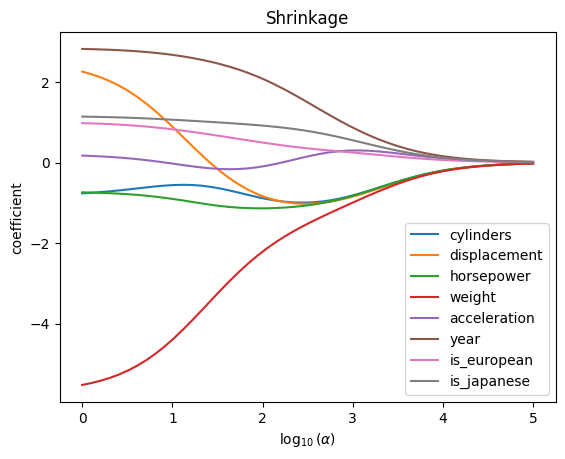

In [42]:
alphas = np.logspace(0, 5, 50)

coefs = np.zeros((50, len(X.columns)))

for i, alpha in enumerate(alphas):
    model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    model.fit(X, y)
    coefs[i] = model[-1].coef_

coefs = pd.DataFrame({c: np.array(coefs)[:, i] for i, c in enumerate(list(X.columns))})
coefs["logalpha"] = np.log10(alphas)

coefs.plot(x="logalpha")
plt.xlabel("$\\log_{10}(\\alpha)$")
plt.ylabel("coefficient")
plt.title("Shrinkage")
plt.show()

In [43]:
param_grid = {
    "polynomialfeatures__degree": [2, 3, 4, 5],
    "ridge__alpha": np.logspace(-2, 1.5, 50),
}

model = make_pipeline(PolynomialFeatures(include_bias=False), StandardScaler(), Ridge())

search = GridSearchCV(
    model,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=RepeatedKFold(n_repeats=100, random_state=42),
)

search.fit(X, y)

ic(search.best_params_)
ic(-search.best_score_)

ic| search.best_params_: {'polynomialfeatures__degree': 3,
                          'ridge__alpha': np.float64(0.08483428982440717)}
ic| -search.best_score_: np.float64(7.502159835049647)


np.float64(7.502159835049647)

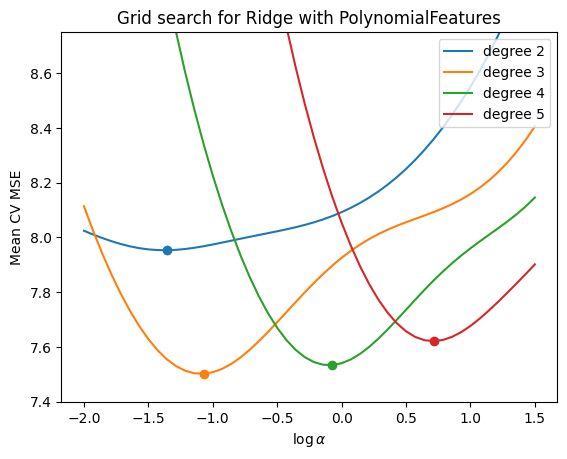

In [44]:
results = pd.DataFrame(search.cv_results_)
for degree, group in results.groupby("param_polynomialfeatures__degree"):
    logalpha = np.log10(group["param_ridge__alpha"].to_numpy())
    meanmse = -group["mean_test_score"].to_numpy()
    j = meanmse.argmin()
    plt.plot(logalpha, meanmse, label=f"degree {degree}")
    plt.plot(logalpha[j], meanmse[j], "o", color=f"C{degree - 2}")

plt.legend(loc="upper right")
plt.ylim(7.4, 8.75)
plt.xlabel("$\\log\\alpha$")
plt.ylabel("Mean CV MSE")
plt.title("Grid search for Ridge with PolynomialFeatures")

plt.show()

### The LASSO

"Least Absolute Selection and Shrinkage Operator"

In [45]:
from sklearn.model_selection import KFold

model = make_pipeline(
    PolynomialFeatures(include_bias=False, degree=2),
    StandardScaler(),
    Lasso(alpha=1e-3, max_iter=1000000),
)

cross_val_score(
    model, X, y, scoring="neg_mean_squared_error", cv=KFold(shuffle=True)
).mean()

np.float64(-7.487962287678849)

In [46]:
param_grid = {
    "polynomialfeatures__degree": [2],
    "lasso__alpha": np.logspace(-3.5, -2.5, 10),
}

model = make_pipeline(
    PolynomialFeatures(include_bias=False), StandardScaler(), Lasso(max_iter=1000000)
)

search = GridSearchCV(
    model,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=RepeatedKFold(n_repeats=10),
    verbose=True,
)

search.fit(X, y)

ic(search.best_params_)
ic(-search.best_score_)

Fitting 50 folds for each of 10 candidates, totalling 500 fits


ic| search.best_params_: {'lasso__alpha': np.float64(0.0014677992676220691),
                          'polynomialfeatures__degree': 2}
ic| -search.best_score_: np.float64(7.857380174775359)


np.float64(7.857380174775359)

Text(0, 0.5, 'mean test score')

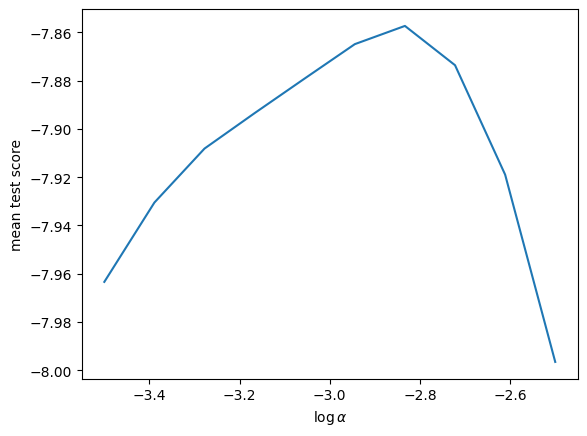

In [47]:
plt.plot(
    np.log10(search.cv_results_["param_lasso__alpha"]),
    search.cv_results_["mean_test_score"],
)
plt.xlabel("$\\log\\alpha$")
plt.ylabel("mean test score")

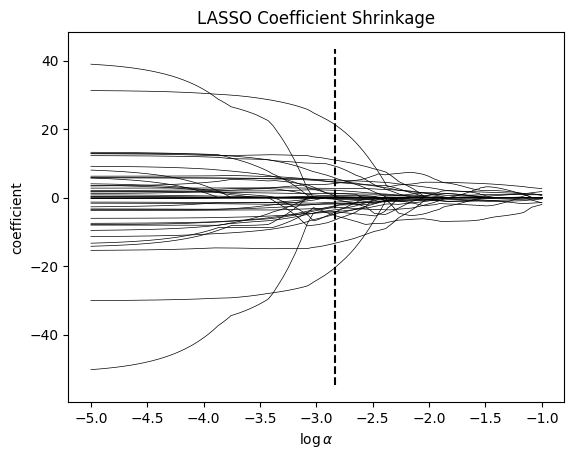

In [48]:
from sklearn.linear_model import lasso_path

preprocessor = make_pipeline(
    PolynomialFeatures(include_bias=False, degree=2), StandardScaler()
)

alphas, coefs, _ = lasso_path(
    preprocessor.fit_transform(X), y, alphas=np.logspace(-5, -1, 1000), max_iter=100000
)

for path in coefs:
    plt.plot(np.log10(alphas), path, "k", lw=0.5)

best_alpha = search.best_params_["lasso__alpha"]
plt.plot([np.log10(best_alpha), np.log10(best_alpha)], plt.ylim(), "k--")

plt.xlabel("$\\log\\alpha$")
plt.ylabel("coefficient")
plt.title("LASSO Coefficient Shrinkage")
plt.show()

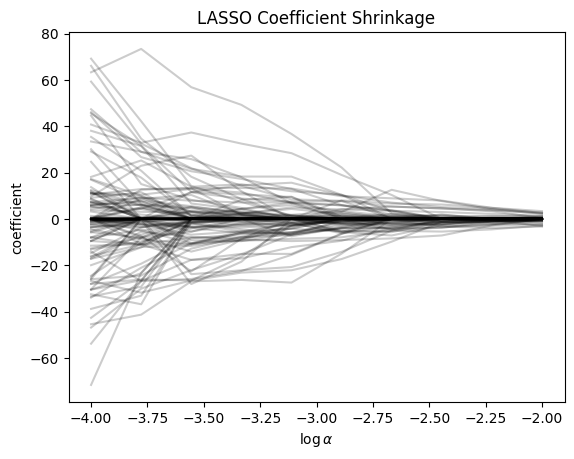

In [49]:
preprocessor = make_pipeline(
    PolynomialFeatures(include_bias=False, degree=3), StandardScaler()
)

alphas, coefs, _ = lasso_path(
    preprocessor.fit_transform(X), y, alphas=np.logspace(-4, -2, 10), max_iter=10000000
)

for path in coefs:
    plt.plot(np.log10(alphas), path, "k", alpha=0.2)


plt.xlabel("$\\log\\alpha$")
plt.ylabel("coefficient")
plt.title("LASSO Coefficient Shrinkage")
plt.show()

##### Back to the ICMR dataset

In [51]:
X = pd.read_csv("data/data.csv").drop(columns=["Unnamed: 0"])
y = pd.read_csv("data/labels.csv")["Class"]

cross_val_score(
    LogisticRegression(penalty="l1", solver="liblinear", C=0.01),
    X,
    y,
    scoring="accuracy",
).mean()

C:\Users\frlin\OneDrive\Documentos\_uofc\2025 Summer\DATA_607\gh_note\DATA607S2025\.venv_home\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\frlin\OneDrive\Documentos\_uofc\2025 Summer\DATA_607\gh_note\DATA607S2025\.venv_home\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\frlin\OneDrive\Documentos\_uofc\2025 Summer\DATA_607\gh_note\DATA607S2025\.venv_home\Lib\site-packages\skle

np.float64(1.0)

In [52]:
model = LogisticRegression(penalty="l1", solver="liblinear", C=0.01)
model.fit(X, y)
np.sum(~np.isclose(model.coef_, 0))

C:\Users\frlin\OneDrive\Documentos\_uofc\2025 Summer\DATA_607\gh_note\DATA607S2025\.venv_home\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


np.int64(193)

In [53]:
set(model.coef_[0].nonzero()[0]).intersection(set(model.coef_[1].nonzero()[0]))

set()

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LogisticRegression(penalty="l1", solver="liblinear", C=0.01)
model.fit(X_train, y_train)

indices_0 = list(zip(*model.coef_.nonzero()))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = LogisticRegression(penalty="l1", solver="liblinear", C=0.01)
model.fit(X_train, y_train)

indices_1 = list(zip(*model.coef_.nonzero()))

C:\Users\frlin\OneDrive\Documentos\_uofc\2025 Summer\DATA_607\gh_note\DATA607S2025\.venv_home\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\frlin\OneDrive\Documentos\_uofc\2025 Summer\DATA_607\gh_note\DATA607S2025\.venv_home\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [55]:
len(set(indices_0)), len(set(indices_1)), len(
    set(indices_0).intersection(set(indices_1))
)

(155, 141, 92)